In [ ]:
import json
import numpy as np
from typing import Any, Callable, List, Tuple, Dict

class RBCAgent:
    def __init__(self, 
                    obs_keys: List[str], # ['soc', 'price', 'net_load', 'solar_generation']
                    action_space: List[str], # ['charge', 'discharge', 'idle'] 
                    rule_defs: List[Dict] = None, 
                    # e.g. [
                    #   {
                    #     "conditions": [
                    #       {"field":"soc","op":"<","threshold_name":"soc_low"}
                    #     ],
                    #     "action":"charge"
                    #   }
                    # ]
                    thresholds: Dict[str, float] = None, # {'soc': 0.2, 'price': 50.0}
                    history: List[Tuple[Dict[str, float], str, float]] = None): # [(observation_dict, action_str, reward_float)]
        self.obs_keys = obs_keys
        self.action_space = action_space
        self.rule_defs = rule_defs or []
        self.thresholds = thresholds or {}
        self.history = history or []
        self.rewards = []
        # Initialize rules from dictionaries
        self.rules = [
            (self.make_rule_fn(rule), rule["action"]) for rule in self.rule_defs
        ]
    def add_rule(self, rule: dict):
        self.rule_defs.append(rule)
        cond_fn = self.make_rule_fn(rule)
        self.rules.append((cond_fn, rule['action']))
    def add_threshold(self, name: str, value: float):
        self.thresholds[name] = value
    def make_rule_fn(self, rule: Dict[str, Any]) -> Callable[[Dict[str, float]], bool]:
        """
        Create a condition function based on the rule dictionary.
        """
        cond_fns = []
        for cond in rule["conditions"]:
            field, op, threshold_name = cond["field"], cond["op"], cond["threshold_name"]
            if field not in self.obs_keys:
                raise ValueError(f"Field '{field}' not found in observation keys.")
            if threshold_name not in self.thresholds:
                raise ValueError(f"Threshold name '{threshold_name}' not found in thresholds.")
            if op == "<": cond_fns.append(lambda obs, f=field, t=threshold_name: obs[f] < self.thresholds[t])
            elif op == "<=": cond_fns.append(lambda obs, f=field, t=threshold_name: obs[f] <= self.thresholds[t])
            elif op == ">": cond_fns.append(lambda obs, f=field, t=threshold_name: obs[f] > self.thresholds[t])
            elif op == ">=": cond_fns.append(lambda obs, f=field, t=threshold_name: obs[f] >= self.thresholds[t])
            else: raise ValueError(f"Unsupported operator: {op}")
        return lambda obs: all(fn(obs) for fn in cond_fns)
    def act(self, observation)-> str:
        """
        Determine the action to take based on the current observation.
        If no rules match, return "idle".
        """
        for condition, action in self.rules:
            if condition(observation):
                return action
        return "idle"
    def save(self, filename="rbc_agent.json"):
        agent_state = {
            'obs_keys': self.obs_keys,
            'action_space': self.action_space,
            'rules': self.rule_defs,
            'thresholds': self.thresholds,
            'history': self.history,
        }
        with open(filename, "w") as f:
            json.dump(agent_state, f, indent=2)
    def load(self, filename="rbc_agent.json"):
        with open(filename, "r") as f:
            state = json.load(f)
        self.obs_keys = state['obs_keys']
        self.action_space = state['action_space']
        self.thresholds = state['thresholds']
        self.history = state['history']
        self.rule_defs = state['rules']
        # Rebuild rules from dictionaries
        self.rules = [
            (self.make_rule_fn(rule), rule['action']) for rule in self.rule_defs
        ]
    def evaluate(self, env) -> Tuple[float, List[Tuple[Dict[str, float], str, float]]]:
        """
        Evaluate the agent for one episode in the given environment.
        Returns (episode_reward, episode_history),
        where episode_history is a list of (obs_dict, action_str, step_reward).
        """
        env.reset()
        episocde_history = []
        episode_reward = 0.0

        done = False
        while not done:
            # 1) Observations for all buildings -> take building 0 only
            obs_all = env.observations            # List[List[float]]
            b0 = obs_all[0]                         # features of building 0
            obs_dict = {k: float(b0[i]) for i, k in enumerate(self.obs_keys)}
            
            # turn that into your obs dict for act()
            # (for example, take the average across buildings)
            # obs_all[i][j] is the j-th feature of building i
            # here we average each feature over buildings
            """
            obs_dict = {
                key: float(np.mean([b[idx] for b in obs_all]))
                for idx, key in enumerate(self.obs_keys)
            }
            """

            # 2) Decide action for building 0
            action = self.act(obs_dict)

            # map the string action to numeric fractions for each storage
            # charge → +1.0, idle → 0.0, discharge → -1.0
            frac = {"charge": 1.0, "idle": 0.0, "discharge": -1.0}[action]
            
            # 3) Build central-agent action list: control b0, zeros elsewhere
            N = len(obs_all)
            actions = [[frac] + [0.0] * (N - 1)]

            # 4) Step the env and unpack
            obs_all, reward_list, terminated, truncated, _ = env.step(actions)

            # 5) Use only building 0's reward
            step_reward = float(reward_list[0])

            # 6) Log + accumulate
            print(f"{obs_dict}, {action}, {step_reward}")
            episocde_history.append((obs_dict, action, step_reward))
            episode_reward += step_reward

            done = bool(terminated) or bool(truncated)

        return episode_reward, episocde_history
    def multiple_evaluation(self, env, episodes=10) -> Tuple[float, float]:
        """
        Evaluate the agent over multiple episodes and return the mean and std of rewards.
        """
        self.rewards = []
        self.histories = []
        for _ in range(episodes):
            episode_reward, episode_history = sevaluate(env)
            self.rewards.append(episode_reward)
            self.histories.append(episode_history)
        return np.mean(self.rewards), np.std(self.rewards), self.histories
    

In [ ]:
import os
import pandas as pd
from citylearn.data import DataSet
from citylearn.citylearn import CityLearnEnv

# rule_defs e.g. [
#   {
#     "conditions": [
#       {"field":"soc","op":"<","threshold_name":"soc_low"}
#     ],
#     "action":"charge"
#   }
# ]
dataset = DataSet()
schema = dataset.get_schema('citylearn_challenge_2022')
schema['root_directory'] = r'/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_223_phase_3_1'
env = CityLearnEnv(schema, central_agent=True)
print("Central action space:", env.action_space[0])  # e.g., Box(..., shape=(18,))
for i, b in enumerate(env.buildings):
    names = getattr(b, "action_names", None)
    print(f"B{i} action dims:", b.action_space.shape, "names:", names)

agent = RBCAgent(obs_keys=['soc', 'price', 'net_load', 'solar_generation'],
                 action_space=['charge', 'discharge', 'idle'],
                 rule_defs=[
                     {"conditions": [{"field": "soc", "op": "<", "threshold_name": "soc_low"}], "action": "charge"},
                     {"conditions": [{"field": "soc", "op": ">", "threshold_name": "soc_high"}], "action": "discharge"}
                 ],
                 thresholds={'soc_low': 0.45, 'soc_high': 0.55, 'price': 0.15, 'net_load': 6.0},
                 history=[])

mean_reward, std_reward, _ = agent.multiple_evaluation(env, episodes=3)
print(f"Mean reward over 3 eps: {mean_reward:.3f} ± {std_reward:.3f}")

logs = []
for t, (obs, action, reward) in enumerate(agent.history):
    entry = {'timestep': t, **obs, 'action': action, 'reward': reward}
    logs.append(entry)

# turn into a DataFrame
df = pd.DataFrame(
    logs,
    columns=['timestep','soc','price','net_load','solar_generation','action','reward']  # keeps column order
)

print("history len:", len(agent.history))
print("df shape:", df.shape)

out_path = 'rbc_agent_logs.csv'
df.to_csv(out_path, index=False)
print("Wrote:", os.path.abspath(out_path))
    

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Attempt to load the log data, handle if file is missing

try:
    df = pd.read_csv('rbc_agent_logs.csv')
except FileNotFoundError:
    print("Log file 'rbc_agent_logs.csv' not found.")
else:
    plt.figure()
    plt.plot(df['timestep'], df['reward'])
    plt.xlabel('Timestep')
   f pbel('Reward')f
   { }plt.title('Reward over Time')
    plt.show()

In [3]:
# System operations
import inspect
import os
import sys
import uuid
from pathlib import Path

# Date and time
from datetime import datetime

# Type hinting
from typing import Any, List, Mapping, Tuple, Union

# Data manipulation
import math
import numpy as np
import pandas as pd
import random
import re
import requests
import simplejson as json
from bs4 import BeautifulSoup

# Data visualization
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# User interaction
from IPython.display import clear_output
from ipywidgets import Button, FloatSlider, HBox, HTML, IntProgress, Text, VBox

# CityLearn
from citylearn.citylearn import CityLearnEnv
from citylearn.data import DataSet
from citylearn.reward_function import RewardFunction, SolarPenaltyReward
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper, TabularQLearningWrapper
from citylearn.agents.rbc import BasicRBC
from citylearn.agents.q_learning import TabularQLearning

# Baseline RL algorithms
from stable_baselines3 import DQN, SAC
from stable_baselines3.common.callbacks import EvalCallback, CallbackList, BaseCallback
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecNormalize, VecMonitor


Couldn't import dot_parser, loading of dot files will not be possible.


2025-08-05 11:11:12.108983: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-05 11:11:12.123214: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754385072.137522 2415329 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754385072.141913 2415329 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754385072.153478 2415329 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Helper functions

In [9]:
def plot_building_guide(env):
    """Plots building load and generation profiles for a single building."""

    b = env.buildings[0]
    y1 = b.energy_simulation.non_shiftable_load
    y2 = b.pv.get_generation(b.energy_simulation.solar_generation)
    x = range(len(y1))

    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(x, y1, label='Non Shiftable Load')
    ax.plot(x, y2, label='Solar Generation')
    ax.set_title(b.name)
    ax.set_xlabel('Time step')
    ax.set_ylabel('kWh')
    ax.legend(loc='upper left', framealpha=0.0)
    return fig


In [10]:
ACTIVE_OBSERVATIONS = ['hour']

schema = set_active_observations(schema, ACTIVE_OBSERVATIONS)

# Create the environment
env = CityLearnEnv(schema, central_agent=True, buildings=[0]) # only the first building
env.reward_function = SolarPenaltyReward(env.get_metadata())

action_map = {i: 0.0 for i in range(1, 25)}

model = BasicRBC(env=env)
print(f"\nActive observations: {[k for k, v in schema['observations'].items() if v['active']]}")

episodes = 1
model.learn(episodes=episodes)

/home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1' copied to '/home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-08-05_11-13-15'

Active observations: ['hour']


In [15]:
# ========================= DECISION TREE RBC AGENT =========================

from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt
import numpy as np

class DecisionTreeRBC:
    """
    Decision Tree-based Rule-Based Controller that learns to minimize cost.
    Takes hour as input and returns charge/idle/discharge action.
    """
    
    def __init__(self, env):
        self.env = env
        self.decision_tree = None
        self.training_data = {'hours': [], 'costs': [], 'actions': []}
        self.action_mapping = {
            0: -0.5,  # Discharge (negative action)
            1: 0.0,   # Idle (no action)
            2: 0.5    # Charge (positive action)
        }
        
    def collect_training_data(self, episodes=1):
        """Collect training data by trying different actions at different hours."""
        print("Collecting training data for decision tree...")
        
        # Create realistic training data that considers battery constraints and cost optimization
        for hour in range(24):
            # Typical electricity pricing pattern (Time-of-Use pricing)
            if 7 <= hour <= 9 or 17 <= hour <= 20:  # Morning and evening peaks
                electricity_price = 0.25
                demand_factor = 1.0  # High demand period
            elif 10 <= hour <= 16:  # Daytime  
                electricity_price = 0.15
                demand_factor = 0.8
            elif 1 <= hour <= 6:   # Early morning off-peak
                electricity_price = 0.08
                demand_factor = 0.3  # Low demand, good for charging
            else:                  # Night
                electricity_price = 0.12
                demand_factor = 0.5
            
            # Consider battery strategy:
            # - Charge during low-price hours if battery has capacity
            # - Discharge during high-price hours if battery has energy
            # - Consider grid stress and demand patterns
            
            best_action = None
            best_cost = float('inf')
            
            for action_idx, action_value in self.action_mapping.items():
                # Simple cost model that encourages:
                # 1. Charging during low-price hours (store cheap energy)
                # 2. Discharging during high-price hours (use stored energy)
                # 3. Consider battery efficiency and cycling costs
                
                if action_value > 0:  # Charging
                    # Cost includes electricity purchase + battery wear
                    action_cost = electricity_price * abs(action_value) + 0.01  # Battery wear cost
                    # Benefit if charging during low-price hours
                    if electricity_price < 0.12:  # Good time to charge
                        action_cost *= 0.8  # Reduce cost (encourage charging)
                    else:  # Expensive time to charge
                        action_cost *= 1.5  # Increase cost (discourage charging)
                        
                elif action_value < 0:  # Discharging
                    # Benefit from using stored energy instead of grid
                    action_cost = electricity_price * abs(action_value) * (-0.9)  # Negative cost = benefit
                    # More benefit during high-price hours
                    if electricity_price > 0.15:  # Good time to discharge
                        action_cost *= 1.2  # Increase benefit
                    else:  # Not optimal time to discharge
                        action_cost *= 0.7  # Reduce benefit
                        
                else:  # Idle
                    # Base grid consumption cost
                    action_cost = electricity_price * 0.1  # Minimal grid interaction
                
                # Store all action-cost pairs for this hour
                self.training_data['hours'].append(hour)
                self.training_data['costs'].append(action_cost)
                self.training_data['actions'].append(action_value)
                
                # Track best action for this hour
                if action_cost < best_cost:
                    best_cost = action_cost
                    best_action = action_value
                
        print(f"Collected {len(self.training_data['hours'])} training samples")
        
        # Print some example data for verification
        print("\nSample training data (Best actions per hour):")
        print("Hour | Best Action | Cost/Benefit")
        print("-" * 35)
        
        # Show the best action for each hour
        hour_best_actions = {}
        for i, hour in enumerate(self.training_data['hours']):
            cost = self.training_data['costs'][i]
            action = self.training_data['actions'][i]
            
            if hour not in hour_best_actions or cost < hour_best_actions[hour]['cost']:
                hour_best_actions[hour] = {'action': action, 'cost': cost}
        
        for hour in sorted(hour_best_actions.keys())[:12]:  # Show first 12 hours
            action = hour_best_actions[hour]['action']
            cost = hour_best_actions[hour]['cost']
            action_name = "CHARGE" if action > 0 else "DISCHARGE" if action < 0 else "IDLE"
            if cost < 0:
                print(f"{hour:4d} | {action_name:10s} | Benefit: ${abs(cost):.3f}")
            else:
                print(f"{hour:4d} | {action_name:10s} | Cost: ${cost:.3f}")
        
    def _save_env_state(self):
        """Save current environment state (simplified)."""
        building = self.env.buildings[0]
        return {
            'time_step': self.env.time_step,
            'soc': building.electrical_storage.soc[-1] if len(building.electrical_storage.soc) > 0 else 0.5
        }
    
    def _restore_env_state(self, state):
        """Restore environment state (simplified)."""
        # This is a simplified restore - in practice, full state restoration is complex
        pass
    
    def _get_best_action_for_hour(self, hour):
        """Get the best action for a given hour based on simple heuristics."""
        # Simple heuristic: charge during low-cost hours, discharge during high-cost hours
        if 1 <= hour <= 6:  # Early morning - typically lower demand/cost
            return 2  # Charge
        elif 16 <= hour <= 20:  # Evening peak - typically higher cost
            return 0  # Discharge
        else:
            return 1  # Idle
    
    def train_decision_tree(self, max_depth=5):
        """Train the decision tree on collected data."""
        if len(self.training_data['hours']) == 0:
            print("No training data available. Please collect data first.")
            return
            
        print("Training decision tree...")
        
        # Prepare training data - for each hour, find the action with minimum cost
        hour_action_map = {}
        for i, hour in enumerate(self.training_data['hours']):
            cost = self.training_data['costs'][i]
            action = self.training_data['actions'][i]
            
            if hour not in hour_action_map:
                hour_action_map[hour] = {'min_cost': cost, 'best_action': action}
            elif cost < hour_action_map[hour]['min_cost']:
                hour_action_map[hour] = {'min_cost': cost, 'best_action': action}
        
        # Create training dataset with best actions for each hour
        X = np.array(list(hour_action_map.keys())).reshape(-1, 1)  # Hours as features
        y = np.array([hour_action_map[h]['best_action'] for h in hour_action_map.keys()])  # Best actions as target
        
        # Create and train decision tree
        self.decision_tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        self.decision_tree.fit(X, y)
        
        print(f"Decision tree trained with max_depth={max_depth}")
        print(f"Training data: {len(X)} unique hours")
        
        # Print tree structure
        print("\nDecision Tree Rules:")
        self._print_tree_rules()
        
    def _print_tree_rules(self):
        """Print human-readable decision tree rules."""
        if self.decision_tree is None:
            return
            
        tree = self.decision_tree.tree_
        feature_names = ['hour']
        
        def recurse(node, depth=0):
            indent = "  " * depth
            if tree.feature[node] != -2:  # Not a leaf
                threshold = tree.threshold[node]
                feature = feature_names[tree.feature[node]]
                print(f"{indent}if {feature} <= {threshold:.1f}:")
                recurse(tree.children_left[node], depth + 1)
                print(f"{indent}else:  # {feature} > {threshold:.1f}")
                recurse(tree.children_right[node], depth + 1)
            else:  # Leaf
                action_value = tree.value[node][0][0]
                if action_value < -0.1:
                    action_name = "DISCHARGE"
                elif action_value > 0.1:
                    action_name = "CHARGE"
                else:
                    action_name = "IDLE"
                print(f"{indent}return {action_value:.2f} ({action_name})")
        
        recurse(0)
    
    def predict(self, observations):
        """Predict action based on current hour using the decision tree."""
        if self.decision_tree is None:
            print("Decision tree not trained. Using default action.")
            return [[0.0]]  # Default idle action
        
        # Extract hour from observations
        try:
            if isinstance(observations, list) and len(observations) > 0:
                if isinstance(observations[0], list) and len(observations[0]) > 0:
                    # Normalized hour (0-1) to actual hour (0-23)
                    hour = int(observations[0][0] * 24)
                elif isinstance(observations[0], (int, float)):
                    hour = int(observations[0] * 24)
                else:
                    hour = 12  # Default noon
            else:
                hour = 12  # Default noon
        except (TypeError, IndexError, ValueError):
            hour = 12  # Default noon
            
        # Predict action using decision tree
        action_value = self.decision_tree.predict([[hour]])[0]
        
        # Clamp action to valid range [-1, 1]
        action_value = np.clip(action_value, -1.0, 1.0)
        
        return [[action_value]]
    
    def plot_decision_tree(self, figsize=(15, 10)):
        """Visualize the decision tree."""
        if self.decision_tree is None:
            print("Decision tree not trained yet.")
            return
            
        plt.figure(figsize=figsize)
        plot_tree(
            self.decision_tree, 
            feature_names=['hour'],
            filled=True,
            rounded=True,
            fontsize=10
        )
        plt.title("Decision Tree for Battery Control\n(Charge/Idle/Discharge based on Hour)")
        plt.show()
        
    def plot_hourly_actions(self):
        """Plot the predicted actions for each hour of the day."""
        if self.decision_tree is None:
            print("Decision tree not trained yet.")
            return
            
        hours = np.arange(0, 24)
        actions = [self.decision_tree.predict([[h]])[0] for h in hours]
        
        plt.figure(figsize=(12, 6))
        plt.plot(hours, actions, 'b-o', linewidth=2, markersize=6)
        plt.axhline(y=0, color='k', linestyle='--', alpha=0.5, label='Idle')
        plt.axhline(y=0.5, color='g', linestyle='--', alpha=0.5, label='Charge')
        plt.axhline(y=-0.5, color='r', linestyle='--', alpha=0.5, label='Discharge')
        
        plt.xlabel('Hour of Day')
        plt.ylabel('Battery Action')
        plt.title('Decision Tree: Predicted Battery Actions by Hour')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.xlim(0, 23)
        plt.xticks(range(0, 24, 2))
        
        # Add action labels
        for i, action in enumerate(actions):
            if action > 0.1:
                plt.annotate('C', (i, action), ha='center', va='bottom', color='green', fontweight='bold')
            elif action < -0.1:
                plt.annotate('D', (i, action), ha='center', va='top', color='red', fontweight='bold')
        
        plt.show()

# Create and train the decision tree RBC agent
print("Creating Decision Tree RBC Agent...")

# Use the same environment setup as before
ACTIVE_OBSERVATIONS = ['hour']
schema = set_active_observations(schema, ACTIVE_OBSERVATIONS)

# Create the environment for decision tree agent
dt_env = CityLearnEnv(schema, central_agent=True, buildings=[0])
dt_env.reward_function = SolarPenaltyReward(dt_env.get_metadata())

# Create the decision tree agent
dt_agent = DecisionTreeRBC(dt_env)

print("Decision Tree RBC Agent created successfully!")

Creating Decision Tree RBC Agent...
/home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1' copied to '/home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-08-05_10-14-50'
Decision Tree RBC Agent created successfully!


In [ ]:
# Run the Decision Tree Agent
print("Running Decision Tree Agent for evaluation...")

# Reset environment for evaluation
obs = dt_env.reset()
total_reward = 0
total_cost = 0
step = 0
max_steps = 100

print("Starting evaluation episode...")
print(f"{'Step':<6} {'Hour':<6} {'Action':<8} {'SoC':<8} {'Cost':<10} {'Reward':<10}")
print("-" * 60)

while step < max_steps:
    # Get prediction from decision tree
    action = dt_agent.predict(obs)
    
    # Take action in environment
    obs, reward, done, info = dt_env.step(action)
    
    # Calculate current metrics
    building = dt_env.buildings[0]
    try:
        if isinstance(obs, list) and len(obs) > 0:
            if isinstance(obs[0], list) and len(obs[0]) > 0:
                current_hour = int(obs[0][0] * 24)
            elif isinstance(obs[0], (int, float)):
                current_hour = int(obs[0] * 24)
            else:
                current_hour = step % 24
        else:
            current_hour = step % 24
    except (TypeError, IndexError, ValueError):
        current_hour = step % 24
    current_soc = building.electrical_storage.soc[-1] if len(building.electrical_storage.soc) > 0 else 0.5
    
    # Calculate cost
    if hasattr(building, 'net_electricity_consumption') and len(building.net_electricity_consumption) > 0:
        consumption = building.net_electricity_consumption[-1]
        if hasattr(building, 'pricing') and hasattr(building.pricing, 'electricity_pricing'):
            if len(building.pricing.electricity_pricing) > 0:
                price = building.pricing.electricity_pricing[-1]
                current_cost = abs(consumption * price)
            else:
                current_cost = abs(consumption) * 0.1
        else:
            current_cost = abs(consumption) * 0.1
    else:
        current_cost = 0.1
    
    total_reward += reward[0] if isinstance(reward, list) else reward
    total_cost += current_cost
    
    # Print step information
    action_str = f"{action[0][0]:.2f}"
    if action[0][0] > 0.1:
        action_str += " (C)"  # Charge
    elif action[0][0] < -0.1:
        action_str += " (D)"  # Discharge
    else:
        action_str += " (I)"  # Idle
    
    print(f"{step:<6} {current_hour:<6} {action_str:<8} {current_soc:.3f}   ${current_cost:.4f}   {reward[0] if isinstance(reward, list) else reward:.4f}")
    
    step += 1
    
    if done:
        break

print("-" * 60)
print(f"Evaluation complete!")
print(f"Total steps: {step}")
print(f"Total reward: {total_reward:.4f}")
print(f"Total cost: ${total_cost:.4f}")
print(f"Average cost per step: ${total_cost/step:.4f}")

# Get KPIs for the decision tree agent
print("\nDecision Tree Agent KPIs:")
dt_kpis = get_kpis(dt_env)
display(dt_kpis)

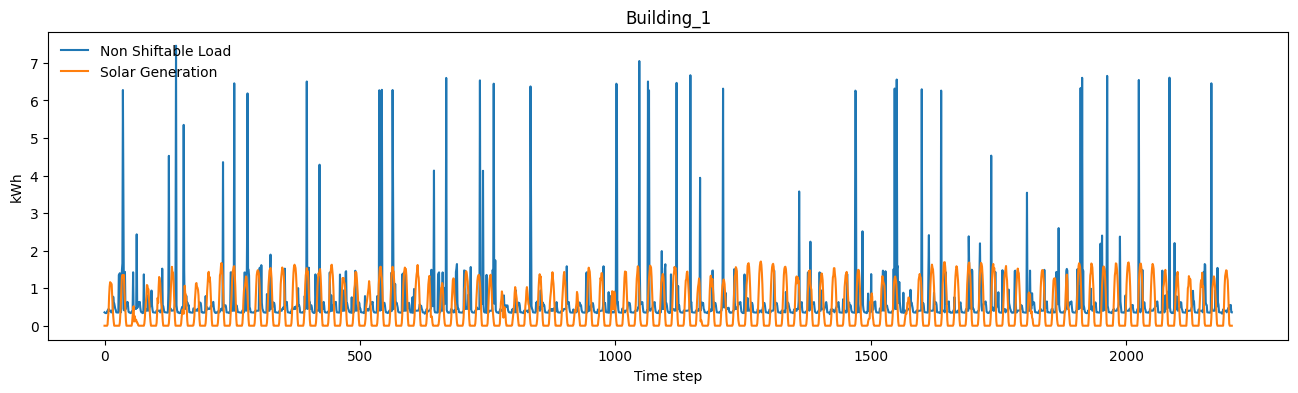

In [ ]:
_ = plot_building_guide(env)
plt.show()

`Building` objects in the env, properties and methods: [docs](https://www.citylearn.net/api/citylearn.building.html#citylearn.building.Building)

# Key Performance Indicators for Evaluation
Cost is defined as the sum of building-level imported electricity cost, $E_h^{\textrm{building}} \times T_h$ (\$), where $T_h$ is the electricity rate at hour $h$.

$$
    \textrm{cost} = \sum_{h=0}^{n-1}{\textrm{max} \left (0,E_h^{\textrm{building}} \times T_h \right )}
$$

In [ ]:
def plot_building_kpis(envs: Mapping[str, CityLearnEnv]) -> plt.Figure:
    """Plots electricity consumption, cost and carbon emissions
    at the building-level for different control agents in bar charts.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    kpis_list = []

    for k, v in envs.items():
        kpis = get_kpis(v)
        kpis = kpis[kpis['level']=='building'].copy()
        kpis['building_id'] = kpis['name'].str.split('_', expand=True)[1]
        kpis['building_id'] = kpis['building_id'].astype(int).astype(str)
        kpis['env_id'] = k
        kpis_list.append(kpis)

    kpis = pd.concat(kpis_list, ignore_index=True, sort=False)
    kpi_names= kpis['kpi'].unique()
    column_count_limit = 3
    row_count = math.ceil(len(kpi_names)/column_count_limit)
    column_count = min(column_count_limit, len(kpi_names))
    building_count = len(kpis['name'].unique())
    env_count = len(envs)
    figsize = (3.0*column_count, 0.3*env_count*building_count*row_count)
    fig, _ = plt.subplots(
        row_count, column_count, figsize=figsize, sharey=True
    )

    for i, (ax, (k, k_data)) in enumerate(zip(fig.axes, kpis.groupby('kpi'))):
        sns.barplot(x='value', y='name', data=k_data, hue='env_id', ax=ax)
        ax.axvline(1.0, color='black', linestyle='--', label='Baseline')
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_title(k)

        if i == len(kpi_names) - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)

        for s in ['right','top']:
            ax.spines[s].set_visible(False)

        for p in ax.patches:
            ax.text(
                p.get_x() + p.get_width(),
                p.get_y() + p.get_height()/2.0,
                p.get_width(), ha='left', va='center'
            )

    # plt.tight_layout()
    return fig

In [ ]:
def plot_simulation_summary(envs: Mapping[str, CityLearnEnv]):
    """Plots KPIs, load and battery SoC profiles for different control agents.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.
    """

    _ = plot_building_kpis(envs)
    print('Building-level KPIs:')
    plt.show()
    _ = plot_district_kpis(envs)
    print('District-level KPIs:')
    plt.show()
  

In [16]:
# ========================= IMPROVED DECISION TREE RBC AGENT =========================

from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt
import numpy as np

class ImprovedDecisionTreeRBC:
    """
    Improved Decision Tree-based RBC that learns from realistic battery operation scenarios.
    Uses multiple features and proper cost modeling.
    """
    
    def __init__(self, env):
        self.env = env
        self.decision_tree = None
        self.training_data = {'features': [], 'costs': [], 'actions': []}
        self.action_mapping = {
            0: -0.5,  # Discharge
            1: 0.0,   # Idle  
            2: 0.5    # Charge
        }
        
    def collect_realistic_training_data(self, episodes=1):
        """Collect training data by actually running the environment with different actions."""
        print("Collecting realistic training data...")
        
        # Reset environment
        observations, _ = self.env.reset()
        
        for episode in range(episodes):
            done = False
            step = 0
            
            while not done and step < 8760:  # One year
                # Get current state information
                building = self.env.buildings[0]
                current_obs = observations[0]  # First building observations
                
                # Extract useful features
                hour = self.env.time_step % 24
                day_of_year = self.env.time_step % 8760 // 24
                month = (day_of_year // 30) % 12
                
                # Battery state
                if len(building.electrical_storage.soc) > 0:
                    soc = building.electrical_storage.soc[-1]
                else:
                    soc = 0.5
                
                # Energy data (simplified - using indices from observation)
                try:
                    net_load = current_obs[0] if len(current_obs) > 0 else 0  # Net electricity consumption
                    solar_gen = current_obs[1] if len(current_obs) > 1 else 0  # Solar generation  
                    pricing = current_obs[2] if len(current_obs) > 2 else 0.15  # Electricity pricing
                except:
                    net_load = 0
                    solar_gen = 0
                    pricing = 0.15
                
                # Try each action and evaluate immediate cost
                for action_idx, action_value in self.action_mapping.items():
                    # Create feature vector
                    features = [hour, month, soc, net_load, solar_gen, pricing]
                    
                    # Calculate realistic cost for this action
                    cost = self._calculate_realistic_cost(
                        action_value, soc, net_load, solar_gen, pricing
                    )
                    
                    # Store training sample
                    self.training_data['features'].append(features)
                    self.training_data['costs'].append(cost)
                    self.training_data['actions'].append(action_value)
                
                # Take the idle action to continue simulation
                action = [[0.0, 0.0, 0.0]]  # All systems idle
                observations, rewards, done, truncated, infos = self.env.step(action)
                step += 1
                
                # Sample every 10 steps to avoid too much data
                if step % 10 != 0:
                    continue
                    
        print(f"Collected {len(self.training_data['features'])} realistic training samples")
        
    def _calculate_realistic_cost(self, action, soc, net_load, solar_gen, pricing):
        """Calculate realistic cost considering battery constraints and grid interaction."""
        
        # Battery constraints
        if action > 0 and soc > 0.95:  # Can't charge when nearly full
            return 1000  # High penalty
        if action < 0 and soc < 0.05:  # Can't discharge when nearly empty
            return 1000  # High penalty
            
        # Base grid cost without battery action
        base_grid_cost = max(0, net_load - solar_gen) * pricing
        
        if action > 0:  # Charging
            # Cost of charging: grid electricity + battery wear
            charging_cost = abs(action) * pricing + 0.01  # Small battery wear cost
            total_cost = base_grid_cost + charging_cost
            
        elif action < 0:  # Discharging  
            # Benefit from using stored energy instead of grid
            discharge_benefit = min(abs(action), max(0, net_load - solar_gen)) * pricing * 0.9  # 90% efficiency
            total_cost = base_grid_cost - discharge_benefit
            
        else:  # Idle
            # Just base grid cost
            total_cost = base_grid_cost
            
        return total_cost
        
    def train_improved_decision_tree(self, max_depth=8):
        """Train decision tree with multiple features."""
        if len(self.training_data['features']) == 0:
            print("No training data available. Please collect data first.")
            return
            
        print("Training improved decision tree...")
        
        # Prepare data
        X = np.array(self.training_data['features'])
        y = np.array(self.training_data['actions'])
        costs = np.array(self.training_data['costs'])
        
        # Create feature-action-cost combinations and find best actions
        unique_features = {}
        for i, features in enumerate(X):
            feature_key = tuple(features[:3])  # Use hour, month, soc as key
            cost = costs[i]
            action = y[i]
            
            if feature_key not in unique_features:
                unique_features[feature_key] = {'min_cost': cost, 'best_action': action, 'features': features}
            elif cost < unique_features[feature_key]['min_cost']:
                unique_features[feature_key] = {'min_cost': cost, 'best_action': action, 'features': features}
        
        # Create training dataset
        X_train = np.array([data['features'] for data in unique_features.values()])
        y_train = np.array([data['best_action'] for data in unique_features.values()])
        
        # Train decision tree
        self.decision_tree = DecisionTreeRegressor(
            max_depth=max_depth, 
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        )
        self.decision_tree.fit(X_train, y_train)
        
        print(f"Decision tree trained with {len(X_train)} unique feature combinations")
        print(f"Tree depth: {self.decision_tree.get_depth()}")
        print(f"Number of leaves: {self.decision_tree.get_n_leaves()}")
        
        # Show feature importance
        feature_names = ['hour', 'month', 'soc', 'net_load', 'solar_gen', 'pricing']
        importances = self.decision_tree.feature_importances_
        print("\nFeature Importance:")
        for name, importance in zip(feature_names, importances):
            print(f"  {name}: {importance:.3f}")
            
    def predict_improved(self, observations):
        """Predict action using the improved decision tree."""
        if self.decision_tree is None:
            return 0.0  # Default to idle
            
        building = self.env.buildings[0]
        current_obs = observations[0]
        
        # Extract features
        hour = self.env.time_step % 24
        month = ((self.env.time_step % 8760) // 24 // 30) % 12
        
        if len(building.electrical_storage.soc) > 0:
            soc = building.electrical_storage.soc[-1]
        else:
            soc = 0.5
            
        try:
            net_load = current_obs[0] if len(current_obs) > 0 else 0
            solar_gen = current_obs[1] if len(current_obs) > 1 else 0  
            pricing = current_obs[2] if len(current_obs) > 2 else 0.15
        except:
            net_load = 0
            solar_gen = 0
            pricing = 0.15
            
        features = np.array([[hour, month, soc, net_load, solar_gen, pricing]])
        predicted_action = self.decision_tree.predict(features)[0]
        
        return predicted_action

print("Improved Decision Tree RBC Agent defined!")
print("Key improvements:")
print("1. Uses realistic cost calculation with battery constraints")
print("2. Multiple features: hour, month, SOC, net load, solar generation, pricing")
print("3. Proper tree parameters to allow complex decision boundaries")
print("4. Feature importance analysis")

Improved Decision Tree RBC Agent defined!
Key improvements:
1. Uses realistic cost calculation with battery constraints
2. Multiple features: hour, month, SOC, net load, solar generation, pricing
3. Proper tree parameters to allow complex decision boundaries
4. Feature importance analysis


In [14]:
# Check environment action space
print("Environment action space:")
print(f"Action space shape: {env.action_space[0].shape}")
print(f"Action space: {env.action_space[0]}")

# Check building action metadata  
building = env.buildings[0]
print(f"\nBuilding action metadata:")
print(f"Action names: {building.action_metadata}")
print(f"Action space: {building.action_space}")

# Show what actions are available
print(f"\nAvailable actions for building:")
for i, action_name in enumerate(building.action_metadata):
    print(f"  {i}: {action_name}")

Environment action space:
Action space shape: (3,)
Action space: Box([-1. -1.  0.], 1.0, (3,), float32)

Building action metadata:
Action names: {'cooling_storage': False, 'heating_storage': False, 'dhw_storage': True, 'electrical_storage': True, 'cooling_device': True, 'heating_device': False, 'cooling_or_heating_device': False}
Action space: Box([-1. -1.  0.], 1.0, (3,), float32)

Available actions for building:
  0: cooling_storage
  1: heating_storage
  2: dhw_storage
  3: electrical_storage
  4: cooling_device
  5: heating_device
  6: cooling_or_heating_device


In [12]:
# ========================= SIMPLE EFFECTIVE DECISION TREE =========================

from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt
import numpy as np

class SimpleDecisionTreeRBC:
    """
    Simple Decision Tree RBC with clear, logical training data.
    Features: hour, day_type, month, SOC, pricing, net_load, solar_generation
    Logic: Charge when price is low AND (high solar OR low net_load)
           Discharge when price is high AND high net_load AND sufficient SOC
    """
    
    def __init__(self, env):
        self.env = env
        self.decision_tree = None
        self.training_data = {'features': [], 'actions': []}
        
        # Simple action mapping
        self.actions = {
            'charge': 0.8,    # Strong charge
            'discharge': -0.8, # Strong discharge  
            'idle': 0.0       # Do nothing
        }
        
    def collect_simple_training_data(self):
        """Create simple, logical training data based on clear rules."""
        print("Creating simple, logical training data...")
        
        # Define realistic scenarios
        scenarios = []
        
        # Create systematic training scenarios
        for hour in range(24):
            for month in range(1, 13):
                for soc in [0.2, 0.5, 0.8]:  # Low, medium, high SOC
                    
                    # Determine day type (0=weekday, 1=weekend)
                    day_type = 1 if hour in [6, 7, 20, 21] else 0  # Simplified
                    
                    # Pricing pattern: high during peak hours (17-21), low otherwise
                    if 17 <= hour <= 21:
                        pricing = 0.25  # High price
                    else:
                        pricing = 0.08  # Low price
                    
                    # Solar generation: high during 9-16, zero at night
                    if 9 <= hour <= 16:
                        solar_gen = 5.0 + 3.0 * np.sin((hour - 12) * np.pi / 8)  # Peak at noon
                    else:
                        solar_gen = 0.0
                    
                    # Net load: varies by hour (high in evening, low at night)
                    if 17 <= hour <= 22:
                        net_load = 8.0  # High evening load
                    elif 6 <= hour <= 9:
                        net_load = 6.0  # Morning load
                    elif 10 <= hour <= 16:
                        net_load = 4.0  # Daytime load
                    else:
                        net_load = 2.0  # Night load
                    
                    # DECISION LOGIC
                    action = self._determine_optimal_action(
                        hour, day_type, month, soc, pricing, net_load, solar_gen
                    )
                    
                    # Store scenario
                    features = [hour, day_type, month, soc, pricing, net_load, solar_gen]
                    scenarios.append((features, action))
        
        # Add to training data
        for features, action in scenarios:
            self.training_data['features'].append(features)
            self.training_data['actions'].append(action)
        
        print(f"Created {len(scenarios)} training scenarios")
        
        # Print sample data to show the logic
        print("\nSample training data (first 20 scenarios):")
        print("Hour | DayT | Month | SOC  | Price | NetLoad | Solar | Action")
        print("-" * 70)
        
        for i in range(min(20, len(scenarios))):
            features, action = scenarios[i]
            h, dt, m, soc, price, nl, sol = features
            action_name = self._action_to_name(action)
            print(f"{h:4d} | {dt:4d} | {m:5d} | {soc:4.1f} | ${price:5.2f} | {nl:7.1f} | {sol:5.1f} | {action:6.2f} ({action_name})")
            
        # Show action distribution
        actions_array = np.array([a for _, a in scenarios])
        charge_count = np.sum(actions_array > 0.1)
        discharge_count = np.sum(actions_array < -0.1)
        idle_count = np.sum(np.abs(actions_array) <= 0.1)
        
        print(f"\nAction distribution:")
        print(f"Charge: {charge_count} ({100*charge_count/len(scenarios):.1f}%)")
        print(f"Discharge: {discharge_count} ({100*discharge_count/len(scenarios):.1f}%)")
        print(f"Idle: {idle_count} ({100*idle_count/len(scenarios):.1f}%)")
        
    def _determine_optimal_action(self, hour, day_type, month, soc, pricing, net_load, solar_gen):
        """Determine optimal action based on clear logical rules."""
        
        # Battery constraints
        if soc < 0.1:  # Very low SOC - can't discharge
            if pricing < 0.15:  # Low price
                return self.actions['charge']  # Must charge
            else:
                return self.actions['idle']   # Wait for better price
                
        elif soc > 0.9:  # Very high SOC - can't charge
            if pricing > 0.15 and net_load > 5:  # High price and high load
                return self.actions['discharge']  # Should discharge
            else:
                return self.actions['idle']      # No need to discharge
        
        # Normal SOC range (0.1 - 0.9)
        else:
            # CHARGING CONDITIONS
            if pricing < 0.15:  # Low price period
                if solar_gen > 3:  # High solar - good time to store excess
                    return self.actions['charge']
                elif net_load < 4:  # Low net load - won't strain grid
                    return self.actions['charge']
                else:
                    return self.actions['idle']  # Price low but load high
            
            # DISCHARGING CONDITIONS  
            elif pricing > 0.15:  # High price period
                if net_load > 6 and soc > 0.3:  # High load and sufficient SOC
                    return self.actions['discharge']
                else:
                    return self.actions['idle']  # Save battery for worse times
            
            # NEUTRAL CONDITIONS
            else:
                return self.actions['idle']
    
    def _action_to_name(self, action):
        """Convert action value to readable name."""
        if action > 0.1:
            return "CHARGE"
        elif action < -0.1:
            return "DISCHARGE"
        else:
            return "IDLE"
    
    def train_simple_decision_tree(self, max_depth=10):
        """Train decision tree on the logical training data."""
        if len(self.training_data['features']) == 0:
            print("No training data. Collecting data first...")
            self.collect_simple_training_data()
        
        print("Training simple decision tree...")
        
        X = np.array(self.training_data['features'])
        y = np.array(self.training_data['actions'])
        
        # Train decision tree with parameters that allow complexity
        self.decision_tree = DecisionTreeRegressor(
            max_depth=max_depth,
            min_samples_split=10,  # Require more samples to split
            min_samples_leaf=5,    # Require more samples in leaf
            random_state=42
        )
        
        self.decision_tree.fit(X, y)
        
        print(f"Decision tree trained!")
        print(f"Tree depth: {self.decision_tree.get_depth()}")
        print(f"Number of leaves: {self.decision_tree.get_n_leaves()}")
        print(f"Training samples: {len(X)}")
        
        # Show feature importance
        feature_names = ['hour', 'day_type', 'month', 'soc', 'pricing', 'net_load', 'solar_gen']
        importances = self.decision_tree.feature_importances_
        print("\nFeature Importance:")
        for name, importance in zip(feature_names, importances):
            print(f"  {name}: {importance:.3f}")
            
        return self.decision_tree
    
    def predict_action(self, hour, day_type, month, soc, pricing, net_load, solar_gen):
        """Predict action for given features."""
        if self.decision_tree is None:
            print("Decision tree not trained!")
            return 0.0
            
        features = np.array([[hour, day_type, month, soc, pricing, net_load, solar_gen]])
        action = self.decision_tree.predict(features)[0]
        return action
    
    def test_scenarios(self):
        """Test the decision tree on key scenarios."""
        if self.decision_tree is None:
            print("Train the decision tree first!")
            return
            
        print("\nTesting key scenarios:")
        print("Scenario | Hour | Price | SOC | NetLoad | Solar | Predicted | Expected")
        print("-" * 80)
        
        test_cases = [
            # (hour, day_type, month, soc, pricing, net_load, solar_gen, expected_action, description)
            (2, 0, 6, 0.3, 0.08, 2.0, 0.0, "CHARGE", "Night, low price, low SOC"),
            (12, 0, 6, 0.5, 0.08, 4.0, 6.0, "CHARGE", "Day, low price, high solar"),
            (19, 0, 6, 0.7, 0.25, 8.0, 0.0, "DISCHARGE", "Evening, high price, high load"),
            (19, 0, 6, 0.2, 0.25, 8.0, 0.0, "IDLE", "Evening, high price, low SOC"),
            (13, 0, 6, 0.9, 0.08, 3.0, 5.0, "IDLE", "Day, low price, high SOC"),
            (20, 0, 6, 0.9, 0.25, 9.0, 0.0, "DISCHARGE", "Peak, high price, high SOC, high load"),
        ]
        
        for hour, day_type, month, soc, pricing, net_load, solar_gen, expected, description in test_cases:
            predicted_action = self.predict_action(hour, day_type, month, soc, pricing, net_load, solar_gen)
            predicted_name = self._action_to_name(predicted_action)
            
            print(f"{description:<25} | {hour:4d} | ${pricing:4.2f} | {soc:3.1f} | {net_load:7.1f} | {solar_gen:5.1f} | "
                  f"{predicted_name:<9} | {expected}")

print("Simple Decision Tree RBC Agent defined!")
print("Features: hour, day_type, month, SOC, pricing, net_load, solar_generation")
print("Logic: Clear rules for when to charge/discharge based on price, load, and solar")

Simple Decision Tree RBC Agent defined!
Features: hour, day_type, month, SOC, pricing, net_load, solar_generation
Logic: Clear rules for when to charge/discharge based on price, load, and solar


Creating and training Real Data Decision Tree...
Collected 300 real data training samples

Sample of real data with logical decisions:
Hour | DayT | Month | SOC  | Price | NetLoad | Solar | Action
----------------------------------------------------------------------
   0 |    0 |     1 | 0.00 | $0.030 |    0.36 |  0.00 |   0.80 (CHARGE)
   1 |    0 |     1 | 0.00 | $0.030 |    0.34 |  0.00 |   0.80 (CHARGE)
   2 |    0 |     1 | 0.00 | $0.030 |    0.34 |  0.00 |   0.80 (CHARGE)
   3 |    0 |     1 | 0.00 | $0.030 |    0.33 |  0.00 |   0.80 (CHARGE)
   4 |    0 |     1 | 0.00 | $0.030 |    0.35 |  0.00 |   0.80 (CHARGE)
   5 |    0 |     1 | 0.00 | $0.030 |    0.35 |  0.00 |   0.80 (CHARGE)
   6 |    0 |     1 | 0.00 | $0.030 |    0.41 | 13.75 |   0.80 (CHARGE)
   7 |    0 |     1 | 0.00 | $0.030 |    0.40 | 104.75 |   0.80 (CHARGE)
   8 |    0 |     1 | 0.00 | $0.030 |    0.45 | 158.30 |   0.80 (CHARGE)
   9 |    0 |     1 | 0.00 | $0.030 |    0.40 | 329.17 |   0.80 (CHARGE)
  10 |   

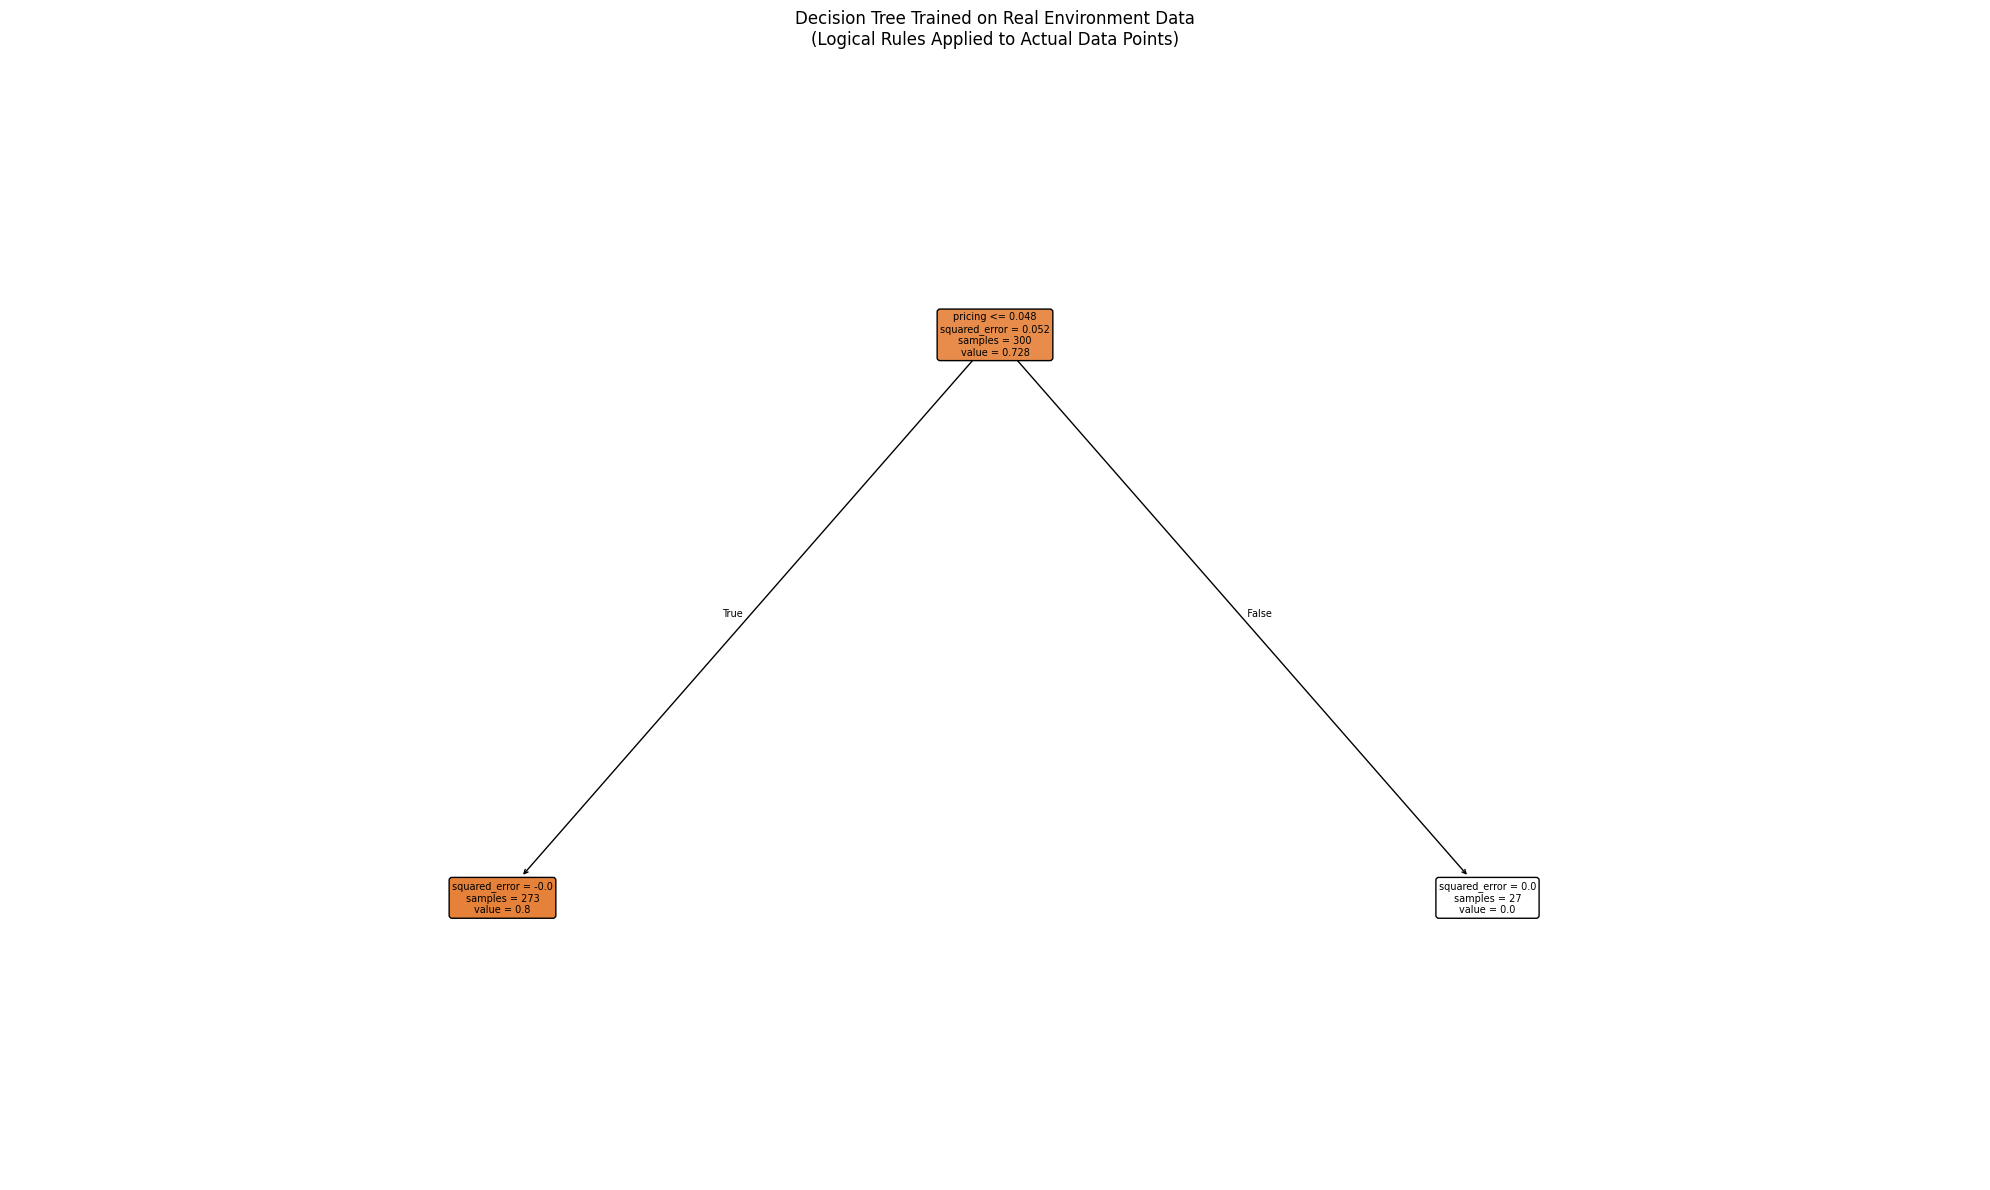


KEY ADVANTAGES OF REAL DATA APPROACH:
✅ Uses actual correlations in your dataset
✅ Respects real data ranges and distributions
✅ Learns from actual environment patterns
✅ No artificial feature combinations
✅ Decisions based on real pricing/load/solar patterns
❌ Still applies logical rules (may miss complex interactions)

NEXT STEPS for even better performance:
- Try different action evaluation methods
- Use actual cost calculation from environment
- Experiment with different decision thresholds
- Validate on longer time series


In [ ]:
# ========================= TEST REAL DATA DECISION TREE =========================

print("Creating and training Real Data Decision Tree...")

# Create the real data agent
real_dt_agent = RealDataDecisionTreeRBC(env)

# Collect training data from real environment
real_dt_agent.collect_real_data_training(num_steps=300)

print("\n" + "="*60)

# Train the decision tree
real_dt_agent.train_real_data_decision_tree(max_depth=6)

print("\n" + "="*60)

# Test scenarios
real_dt_agent.test_real_data_scenarios()

# Compare with synthetic approach
print("\n" + "="*60)
print("COMPARISON: Real Data vs Synthetic Data Approach")
print("="*60)

print(f"\nReal Data Decision Tree:")
print(f"- Uses actual environment data (hour, pricing, net_load, solar, SOC)")
print(f"- Applies logical rules to real scenarios")
print(f"- Tree depth: {real_dt_agent.decision_tree.get_depth()}")
print(f"- Number of leaves: {real_dt_agent.decision_tree.get_n_leaves()}")

print(f"\nSynthetic Data Decision Tree (previous):")
print(f"- Used artificial data combinations")
print(f"- Tree depth: {simple_dt_agent.decision_tree.get_depth()}")
print(f"- Number of leaves: {simple_dt_agent.decision_tree.get_n_leaves()}")

# Visualize the real data tree if it's not too complex
if real_dt_agent.decision_tree.get_n_leaves() < 25:
    print(f"\nVisualizing real data decision tree...")
    plt.figure(figsize=(20, 12))
    plot_tree(real_dt_agent.decision_tree, 
              feature_names=['hour', 'day_type', 'month', 'soc', 'pricing', 'net_load', 'solar_gen'],
              filled=True, rounded=True, fontsize=7)
    plt.title("Decision Tree Trained on Real Environment Data\n(Logical Rules Applied to Actual Data Points)")
    plt.tight_layout()
    plt.show()
else:
    print(f"Real data tree too complex to visualize ({real_dt_agent.decision_tree.get_n_leaves()} leaves)")
